In [2]:
import sys

sys.path.append("../sketchformer")
sys.path.append("../src")


In [3]:
from isketcher import InteractiveSketcher
import tensorflow as tf
import numpy as np
import pandas as pd


In [4]:
num_layers = 8
d_model = 64
dff = 128
num_heads = 4
dropout_rate = 0.1
target_object_num = 41


In [5]:
# create model

interactive_sketcher = InteractiveSketcher(
    num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
    object_num=target_object_num, rate=dropout_rate)

# restore model
# checkpoint_path = "../models/model_6"
checkpoint_path = "../src/checkpoints"

ckpt = tf.train.Checkpoint(epoch=tf.Variable(1),
                           transformer=interactive_sketcher)

ckpt_manager = tf.train.CheckpointManager(
    ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')


Latest checkpoint restored!!


In [18]:
dataset = np.load('../data/isketcher/dataset.npz')
x_test, y_test = dataset['x_test'], dataset['y_test']
print(x_test.shape)
print(y_test.shape)


(1113, 43, 132)
(1113, 43)


In [19]:
# class label
df = pd.read_csv('../outputs/sketchyscene_quickdraw.csv')
df = df.dropna(subset=['quickdraw_label'])
class_names = ['none']
for row in df.itertuples():
    class_names.append(row.quickdraw_label)
class_to_num = dict(zip(class_names, range(0, len(class_names))))

print(class_names)
print(len(class_names))
print(class_to_num)


['none', 'airplane', 'apple', 'hot air balloon', 'banana', 'basket', 'bee', 'bench', 'bicycle', 'bird', 'wine bottle', 'bucket', 'bus', 'butterfly', 'car', 'cat', 'chair', 'cloud', 'cow', 'cup', 'dog', 'duck', 'fence', 'flower', 'grapes', 'grass', 'horse', 'house', 'moon', 'mountain', 'face', 'pig', 'rabbit', 'sheep', 'star', 'streetlight', 'sun', 'table', 'tree', 'truck', 'umbrella']
41
{'none': 0, 'airplane': 1, 'apple': 2, 'hot air balloon': 3, 'banana': 4, 'basket': 5, 'bee': 6, 'bench': 7, 'bicycle': 8, 'bird': 9, 'wine bottle': 10, 'bucket': 11, 'bus': 12, 'butterfly': 13, 'car': 14, 'cat': 15, 'chair': 16, 'cloud': 17, 'cow': 18, 'cup': 19, 'dog': 20, 'duck': 21, 'fence': 22, 'flower': 23, 'grapes': 24, 'grass': 25, 'horse': 26, 'house': 27, 'moon': 28, 'mountain': 29, 'face': 30, 'pig': 31, 'rabbit': 32, 'sheep': 33, 'star': 34, 'streetlight': 35, 'sun': 36, 'table': 37, 'tree': 38, 'truck': 39, 'umbrella': 40}


In [8]:
def from_yolo(x, y, w, h):
    x0 = x - (w / 2)
    y0 = y - (h / 2)
    x1 = x + (w / 2)
    y1 = y + (h / 2)
    return x0, y0, x1, y1

In [9]:
# test

scene_index = 1
print(x_test[scene_index].shape)

print("----", 0, "-------")
print("real label: ", class_names[int(y_test[scene_index, 0])])
print("real position: ", x_test[scene_index, 0, -4:] * 750)

for i in range(1, len(x_test[scene_index])):

    c_out, p_out, _ = interactive_sketcher(
        x_test[scene_index, :i], training=False, look_ahead_mask=None)

    c_real_id = int(y_test[scene_index, i])
    if c_real_id == 0:
        break
    p_real = x_test[scene_index, i, -4:]

    c_pred = c_out[0, -1, :]  # 最後のスケッチを取得
    c_pred_id = tf.argmax(c_pred, axis=-1)
    p_pred = p_out[0, -1, :]  # 最後のスケッチを取得

    print("----", i, "-------")
    print("real label: ", class_names[c_real_id])
    print("pred label: ", class_names[c_pred_id])

    print("real position: ", p_real * 750)
    print("pred position: ", p_pred.numpy() * 750)


(92, 132)
---- 0 -------
real label:  duck
real position:  [315. 650.  70.  40.]
---- 1 -------
real label:  cloud
pred label:  airplane
real position:  [130.      215.      200.00002  90.     ]
pred position:  [261.59586  373.68607  131.72327  105.825226]
---- 2 -------
real label:  cloud
pred label:  rabbit
real position:  [484.99997 265.      170.       90.     ]
pred position:  [422.8415  409.33975 549.0751  287.1698 ]
---- 3 -------
real label:  mountain
pred label:  bicycle
real position:  [345.      380.      750.      219.99998]
pred position:  [418.85623 426.42175 729.652   252.17296]
---- 4 -------
real label:  tree
pred label:  mountain
real position:  [ 95. 410. 190. 340.]
pred position:  [500.31763 551.5426  162.19472 149.27003]
---- 5 -------
real label:  tree
pred label:  car
real position:  [270.      450.00003 140.      260.     ]
pred position:  [566.6041  558.4191  125.0651  120.07641]
---- 6 -------
real label:  tree
pred label:  table
real position:  [520.      460

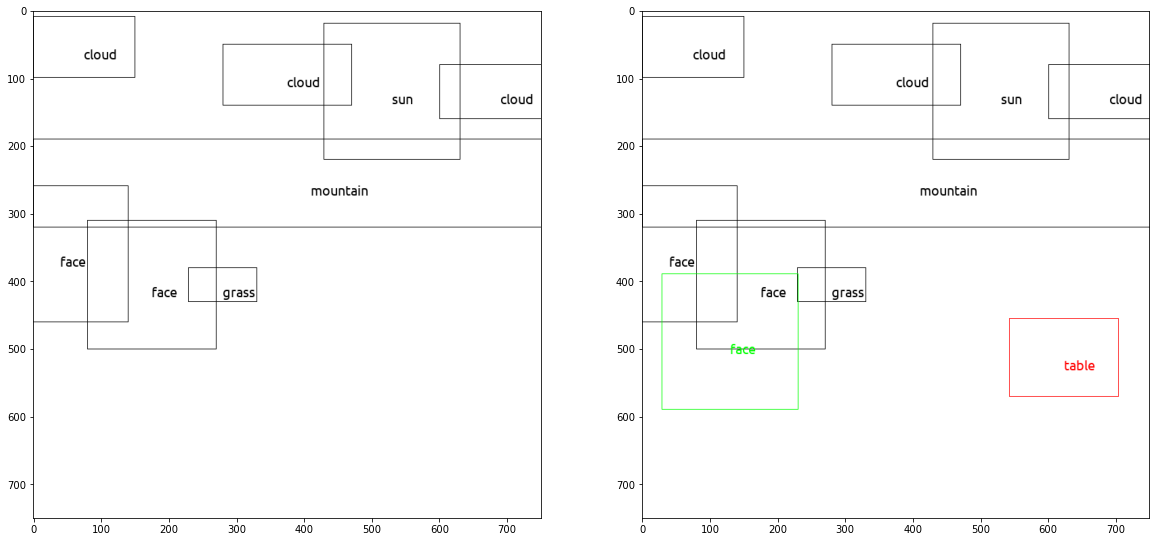

In [21]:
# draw canvas

from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

canvas = Image.new('RGB', (750, 750), (255, 255, 255))

scene_index = 5
pred_index = 8

draw = ImageDraw.Draw(canvas)
r = 5
font = ImageFont.truetype("/usr/share/fonts/truetype/ubuntu/Ubuntu-R.ttf", size=20)

for i in range(pred_index):
    label = class_names[int(y_test[scene_index, i])]
    x, y, w, h = x_test[scene_index, i, -4:] * 750
    x0, y0, x1, y1 = from_yolo(x, y, w, h)
    draw.rectangle((x0, y0, x1, y1), outline=(0, 0, 0))
    draw.text((x, y), label, fill='black', font=font)

# predict
c_out, p_out, _ = interactive_sketcher(
    x_test[scene_index, :pred_index], training=False, look_ahead_mask=None)

c_pred = c_out[0, -1, :]  # 最後のスケッチを取得
c_pred_id = tf.argmax(c_pred, axis=-1)
x, y, w, h = p_out[0, -1, :] * 750  # 最後のスケッチを取得
x0, y0, x1, y1 = from_yolo(x, y, w, h)

next_canvas = canvas.copy()
next_draw = ImageDraw.Draw(next_canvas)
next_draw.rectangle((x0, y0, x1, y1), outline=(255, 0, 0))
next_draw.text((x, y), class_names[c_pred_id], fill=(255, 0, 0), font=font)

# actual
xp, yp, wp, hp = x_test[scene_index, pred_index, -4:] * 750
x0p, y0p, x1p, y1p = from_yolo(xp, yp, wp, hp)
next_draw.rectangle((x0p, y0p, x1p, y1p), outline=(0, 255, 0))
next_draw.text((xp, yp), class_names[int(y_test[scene_index, pred_index])], fill=(0, 255, 0), font=font)

# canvas.save(f'../outputs/canvas_{scene_index}_{pred_index}.png')
# next_canvas.save(f'../outputs/next_canvas_{scene_index}_{pred_index}.png')
plt.figure(figsize=(20, 20))
plt.subplot(121).imshow(canvas)
plt.subplot(122).imshow(next_canvas)